# 1️⃣ - Readings

1. ```NLP From Scratch: Classifying Names With a Character-Level RNN — PyTorch Tutorials```

  Retrieved from: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html?highlight=nlp

  This tutorial forms the basis of this workbook. Here you can read about the initial process of setting up a Character-Level RNN using PyTorch. Skim the first section and focus most of your attention on the 'Creating the Network' section as it describes the backbone of the code you will be working on, and we will use a different dataset. Think carefully about all the layers present and their functionalities

🙋🏻‍♀️ Q1: How many layers does the network in the tutorial have and what is the purpose of each one?

**<< Model Answer >>**

There are three layers:

- Linear i2o (input to output): finds the optimized features matrix for the current next letter.
- Linear i2h (input to hidden): updates the hidden state (optimizing gradients) based on the new character analyzed by the network.
- Softmax: Translates the features matrix received from the i2o layers to Multinomial Probability distributions and determines the most likeli characters to come next in the string after the current analyzed one.

**<< End of Model Answer >>**

🙋🏻‍♀️ Q2: What is the `line hidden = torch.zeros(1, n_hidden)` doing and why? 

**<< Model Answer >>**

For the first unrolling of the network, aka the first letter, the hidden state is just a vector of zeroes with a length equal to the number of neurons we want to have in the hidden state (initialized using torch.zeros(1, self.hidden_size) in PyTorch) because we know nothing yet about the gradients that optimize our guess. Then with every letter analyzed, the hidden state is updated to account for the previous letters. It is achieved in the input-to-hidden layer using a linear activation function.

**<< End of Model Answer >>**

2. ```PyTorch Documentation```

  Retrieved from: https://pytorch.org/docs/stable/index.html

  The 'Search Docs' field in the top left corner of this website might become handy if you don't understand some of the PyTorch functions or just want to explore more techniques. 

🙋🏻‍♀️ Q3: Using search engine in the PyTorch Documentation learn what negative log likelihood loss function is and how it is initialized in Python

**<< Model Answer >>**

The function is initialized by `torch.nn.NLLLoss()`. It is used to measure how good a classifier is, specifically, how far a predicted probability distribution for given categories is from the true distribution.

**<< End of Model Answer >>**

3. ```SMILES Tutorial | Research | US EPA```

  Retrieved from: https://archive.epa.gov/med/med_archive_03/web/html/smiles.html

  This tutorial describes how one can translate a molecular formula of a chemical to a string of letters and characters such as '-', '=', '*', '.' so that a machine learning algorithm can properly learn the sequences of atoms in the molecule. Please, familiarize yourself with general rules, so it is easier to interpret the output of the model. 

🙋🏻‍♀️ Q4: Is 'HC=CH' a valid SMILES string?

**<< Model Answer >>**

No, because in organic molecules, the Carbon bindings not taken by other atoms are implicitely occupied by Hydrogen atoms. E.g., 'HC=CH' is just 'C=C'.

**<< End of Model Answer >>**

3. ```Norman descriptors and predicted LC50```

  Retrieved from: 	https://uvaauas.figshare.com/articles/dataset/Norman_descriptors_and_predicted_LC50/20089787

  The SMILES dataset you will analyze in this workbook is taken from the Amsterdam University of Applied Sciences linked above. Please, get familiar with the column names and what they mean. For example, 'LC50[-LOG(mol/L)]' includes data about the lethal concentrations of all the molecules in the dataset. Think of the column you would like to use to categorize all the data. For example, you might group molecules by their monoisotopic mass. 

🙋🏻‍♀️ Q5: What column in the dataset would you use to categorize the data and why? How do you think the predicted atoms at the end of the molecule would differ based on the categorization you chose?

**<< Model Answer >>**

Monoisotopic mass: I would love to see how the atoms predicted at the end of the string would depend on the monoisotopic group we want the molecule to have. E.g., if we have 'light,' 'medium,' and 'heavy' categories, would the atoms after 'NC' be different? I would expect that for the lighter category, we'll have lighter particles suggested, such as Nitrogen, and for the heavier category, we'll offer bigger atoms, such as Sulfur. 

**<< End of Model Answer >>**

# 2️⃣ - Pre-Class Work

During this class, you will develop a character-level RNN similar to the one you analyzed in the first reading of this PCW. However, instead of predicting a category a given string belongs to, you will increase the input string by adding more characters based on a category this string belongs to. Also, instead of analyzing natural language words, you will peek into the world of bioinformatics and work with molecular formulas and their encodings. Specifically, you will have to predict atoms that should continue the input fraction of the molecule based on some molecular category you chose. For example, you might research how the RNN completes molecules differently for different monoisotopic groups such as  'light,' 'medium,' and 'heavy' molecules. 

To get a better grasp of the model we focus on during the class, please, analyze the figure below. 

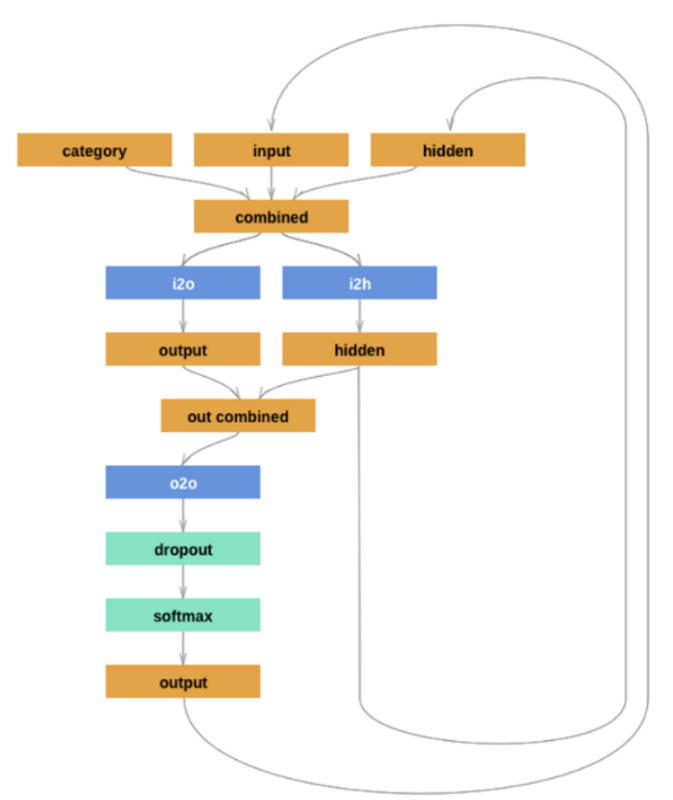

**Q1:** How is this graph different from the one in the reading? What are the additional elements, and what do you think they might be in charge of?

**<< Model Answer >>**

- The output-to-output (o2o) layer that allows us to run the features optimization process once again on the current output and updated the hidden state to improve our predictions at a current letter. 

- The dropout layer that zeroes random parts of the input 2d o2o matrix to simulate corruption of the file and add noise, and, therefore, help us avoid overfitting.

**<< End of Model Answer >>**

**Q2:** Now it's time to prepare everything needed for the RNN. In the code cells below, please import the data set from the readings and categorize it based on your chosen category. Use the readings as a guideline.


In [ ]:
### EXAMPLE CODE

import pandas as pd 
import numpy as np

#Please, import the dataset from 
## https://uvaauas.figshare.com/articles/dataset/Norman_descriptors_and_predicted_LC50/20089787
#Since it is too big I cannot include it into the zip folder

df = pd.read_csv('LC50 dataset.csv')
smiles_list = np.asanyarray(df.SMILES)
df.rename(columns = {'LC50[-LOG(mol/L)]':'LC50'}, inplace = True)
LC50_list = np.asanyarray(df.LC50)

all_categories = ['<3', '3-5', '>6']
filtered = []

for lower, upper in [(0, 4), (4, 6), (6, 9)]:
    curr = []
    for idx in range(len(LC50_list)):
        if LC50_list[idx] >= lower and LC50_list[idx] < upper:
            curr.append(smiles_list[idx])      
    filtered.append(curr)

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
category_lines[all_categories[0]] = [unicodeToAscii(line) for line in filtered[0]]
category_lines[all_categories[1]] = [unicodeToAscii(line) for line in filtered[1]]
category_lines[all_categories[2]] = [unicodeToAscii(line) for line in filtered[2]]

n_categories = len(all_categories)    


# In-Class Activity 

In your Pre-Class work, you've gotten a bit closer to bioinformatics and learned how to encode molecules in your machine-learning algorithms. Hopefully, you could also import the dataset and already categorize it as you wish (if not, please reach out to Professor for help.) Now, it is time to get to something more fun and build the actual RNN that would help us create ✨new molecules✨.

In the code cell below you see the setup for the network you analyzed in the pre-classwork. Now, try building on it and add the layers from the pre-class work diagram that this neural network is yet lacking (please refer to the figure below as a reminder.)

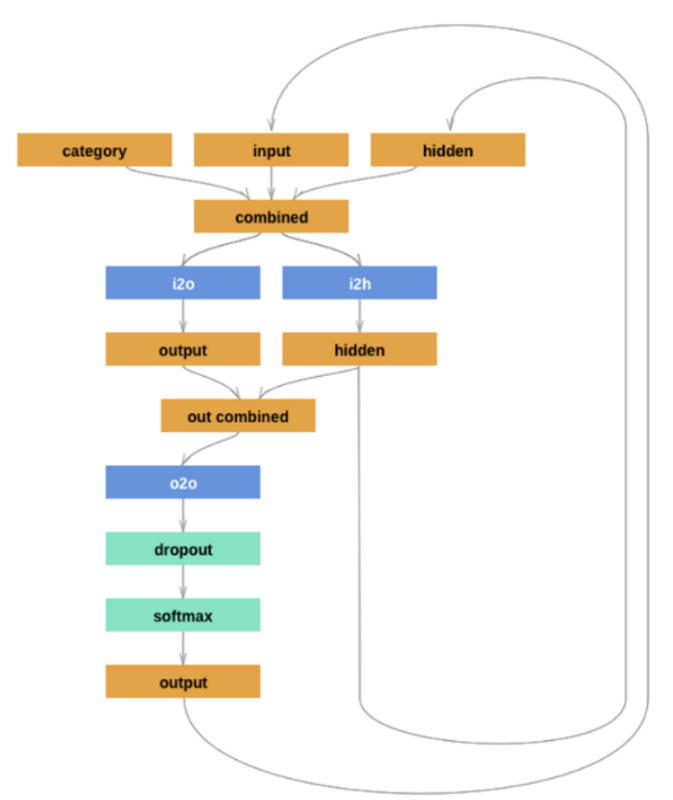

Also, make sure to adjust your forward propagation (forward(self, category, input, hidden)) to account for the new layers.

Hint: you'll need to adjust input_combined variable to account for the new category tensor. Also, you'll have to concatenate twice - first, in the beginning as it was done in the readings, and again to adjust the input for the new layers. 

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        # Add your code here!
        #self. = 
        #self. = 
        '''
        EXAMPLE CODE (NEEDS TO BE REMOVED FOR THE ACTUAL WORKBOOK)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        '''
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((input, hidden), 1) #Adjust this string
        ### MODEL CODE: input_combined = torch.cat((category, input, hidden), 1
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        '''
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        '''
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In the code cells below, we are preparing functions needed for training the network. Carefully look through the code and note any questions you have.

Finally, adjust the code for `inputTensor(line)` to initialize zero-vectors for the characters' one-hot encodings. It must be very similar to the logic in `categoryTensor(category)`.

In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    # What code is missing here?
    ### MODEL CODE: tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Now when you know how to build and prepare everything for the RNN, let's train it.

Set the criterion variable to the function you want to use to measure the accuracy of your model and apply it in the training function. 

In [2]:
criterion = ... ### MODEL CODE:nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion() # Complete the function call here
        ### MODEL CODE: l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

Now, train the network and analyze its behavior throughout the time. How is your metric changing with the number of iterations? What does it imply? Prepare to discuss this with your class after the Breakout Activity. 

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_metrics = []
total_metric = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, metric = train(*randomTrainingExample())
    total_metric += metric

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, metric))

    if iter % plot_every == 0:
        all_metrics.append(total_metric / plot_every)
        total_metric = 0

import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.plot(all_metrics)

Finally, sample from your network and complete the molecules that start with the atoms you want! Analyze the output and describe how it is similar to/different from what you expected.

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='C'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

# Sample here
### MODEL CODE: samples('<3', 'CN')